In [4]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [5]:
date = '20220712'
dataNo = 1
scanNo = 1

In [6]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [32]:
param_name ='T0049: LS ramp up time (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[7]
sample3 = unique_param[15]
unit = '[us]'
flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [8]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '15000.0[us]')

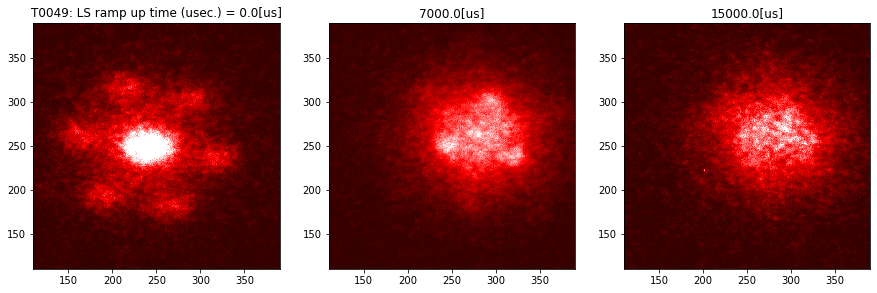

In [9]:
vmin = 0
vmax = 1000
xlim_1 = 110
xlim_2 = 390
ylim_1 = 110
ylim_2 = 390

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [10]:
img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            img_temp.append(img_trans_list[j])
    img_ave_by_unique_param.append(np.average(img_temp, axis=0))

In [11]:
change = True
while change:
    change = False
    for i in range(len(unique_param)-1):
        if unique_param[i]>unique_param[i+1]:
            unique_param[i], unique_param[i+1] = unique_param[i+1], unique_param[i]
            img_ave_by_unique_param[i], img_ave_by_unique_param[i+1] = img_ave_by_unique_param[i+1], img_ave_by_unique_param[i]
            change = True

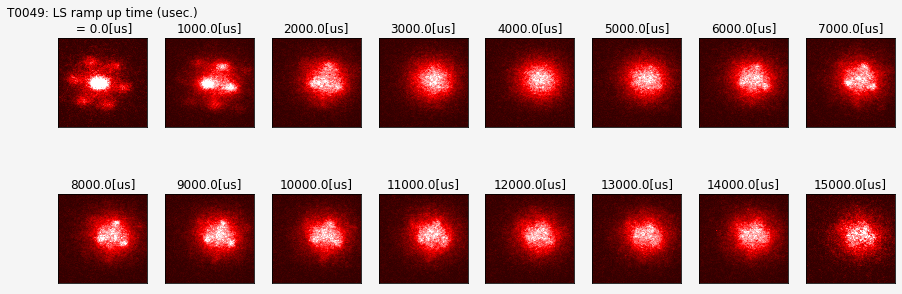

In [25]:
vmin = 0
vmax = 900
xlim_1 = 110
xlim_2 = 390
ylim_1 = 110
ylim_2 = 390

column_number = 8
row_number = 2

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title(param_name+ "\n = %.01f"%(unique_param[column_number*i+j])+unit)
            else:
                axes[i,j].set_title("%.01f"%(unique_param[column_number*i+j])+unit)

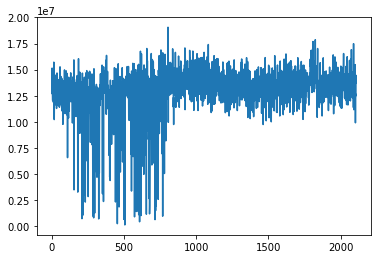

In [13]:
flCount = scan_data['Total count1 @ ROI1 (arb. u.)']
plt.plot(flCount)

In [14]:
postSelected_trans_files = []
postSelected_img_trans_list = []
postSelected_scan_param_list = []
threshold = 4e06

for i in range(len(trans_files)):
    if flCount[i] > threshold:
        postSelected_trans_files.append(trans_files[i])
        postSelected_img_trans_list.append(img_trans_list[i])
        postSelected_scan_param_list.append(scan_param[i])

In [15]:
CoMx_list=[]
CoMy_list=[]
for N in range(len(postSelected_trans_files)):
    CoMy = []
    CoMx = []
    nx=np.sum(postSelected_img_trans_list[N], axis=0)/np.sum(postSelected_img_trans_list[N])
    ny=np.sum(postSelected_img_trans_list[N], axis=1)/np.sum(postSelected_img_trans_list[N])
    for i in range(len(nx)):
        CoMx += [i*nx[i]]
    for i in range(len(ny)):
        CoMy += [i*ny[i]]
    CoMx_list.append(np.sum(CoMx))
    CoMy_list.append(np.sum(CoMy))

In [16]:
centerx_list = []
centery_list = []
centerx_err_list = []
centery_err_list = []

for i in range(len(unique_param)):
    centerx_temp = []
    centery_temp = []
    for j in range(len(postSelected_trans_files)):
        if postSelected_scan_param_list[j] == unique_param[i]:
            centerx_temp.append(CoMx_list[j])
            centery_temp.append(CoMy_list[j])
    centerx_list.append(np.mean(centerx_temp))
    centery_list.append(np.mean(centery_temp))
    centerx_err_list.append(np.std(centerx_temp))
    centery_err_list.append(np.std(centery_temp))

In [17]:
postSelected_img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(postSelected_trans_files)):
        if postSelected_scan_param_list[j] == unique_param[i]:
            img_temp.append(postSelected_img_trans_list[j])
    postSelected_img_ave_by_unique_param.append(np.average(img_temp, axis=0))

(-15.0, 15.0)

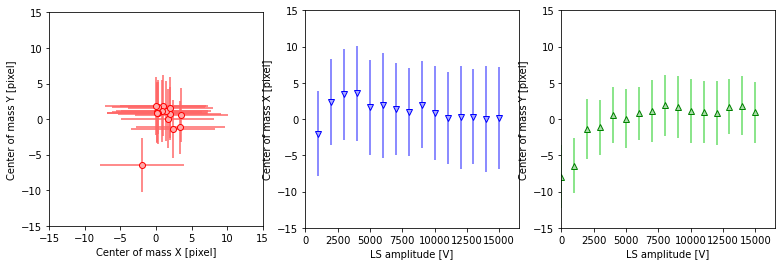

In [30]:
y_mean = np.mean(CoMy_list)
x_mean = np.mean(CoMx_list)
fig =plt.figure(figsize=[13,4])
fig.tight_layout()
ax1 = fig.add_subplot(1,3,1)
ax1.errorbar(centerx_list-x_mean, centery_list-y_mean,xerr=centerx_err_list,yerr=centery_err_list,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa')
ax1.set_xlabel("Center of mass X [pixel]")
ax1.set_ylabel("Center of mass Y [pixel]")
ax1.set_xlim(-15,15)
ax1.set_ylim(-15,15)
ax1.set_aspect('equal')

ax2 = fig.add_subplot(1,3,2)
ax2.errorbar(unique_param,centerx_list-x_mean, yerr=centerx_err_list, fmt='v',c='#6666ff', mec='b', mfc='#aaaaff',label='Side 1')
ax2.set_xlabel("LS amplitude [V]")
ax2.set_ylabel("Center of mass X [pixel]")
ax2.set_xlim(1.1*np.min(unique_param),1.1*np.max(unique_param))
ax2.set_ylim(-15,15)

ax3 = fig.add_subplot(1,3,3)
ax3.errorbar(unique_param,centery_list-y_mean, yerr=centery_err_list,fmt='^', c='#66dd66', mec='g', mfc='#aaddaa')
ax3.set_xlabel("LS amplitude [V]")
ax3.set_ylabel("Center of mass Y [pixel]")
ax3.set_xlim(1.1*np.min(unique_param),1.1*np.max(unique_param))
ax3.set_ylim(-15,15)


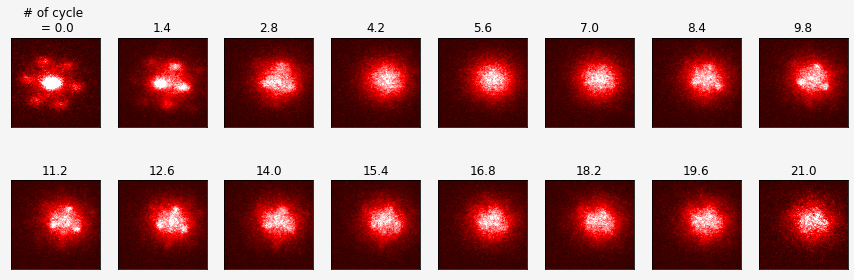

In [37]:
column_number = 8
row_number = 2

LSfreq = 1400 #[Hz]

NoOfCycle = unique_param*LSfreq*1e-6

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.1)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(postSelected_img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title("# of cycle \n = %.01f"%(NoOfCycle[column_number*i+j]))
            else:
                axes[i,j].set_title("%.01f"%(NoOfCycle[column_number*i+j]))

In [38]:
unique_param_index = 2

def createUniqueTransFiles(img_trans_list, scan_param, unique_param, unique_param_index):
    unique_trans_files = []
    for i in range(len(img_trans_list)):
        if scan_param[i] == unique_param[unique_param_index]:
            unique_trans_files.append(img_trans_list[i])
    return unique_trans_files

unique_trans_files = createUniqueTransFiles(postSelected_img_trans_list, postSelected_scan_param_list, unique_param, unique_param_index)

In [39]:
cx = centerx_list[unique_param_index]
cy = centery_list[unique_param_index]
r = 9
momentum_peaks_C1_dx_list = [30, -31, 8]
momentum_peaks_C1_dy_list = [-20, -9, 31]
momentum_peaks_C2_dx_list = [-5, 35, -27]
momentum_peaks_C2_dy_list = [-29, 12, 24]

shift_dx_list = []
shift_dy_list = []
list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))

subROI_cx_list = cx+np.array(shift_dx_list)
subROI_cy_list = cy+np.array(shift_dy_list)

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

c:\Users\Lab\anaconda3\envs\qgm1\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


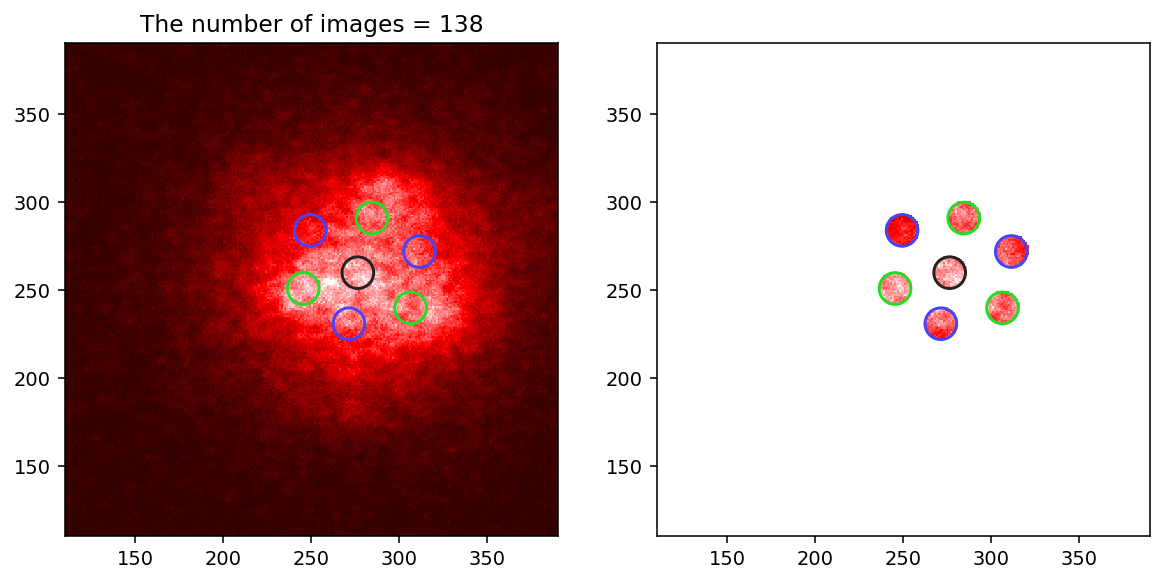

In [40]:
vmin = 0
vmax = 1000
fig =plt.figure(figsize=[10,5],dpi = 140)
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(unique_trans_files)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(shift_dx_list)):
    ax2.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(shift_dx_list)):
    if i == 0:
        color = '#222222'
    elif i<4:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=1.5)
    region.plot(ax=ax2, color=color, lw=1.5)

In [41]:
def calculateVisibility(trans_files, subROI_cx_list, subROI_cy_list, r):
    center_list = []
    side1_list = []
    side2_list = []
    visibility_list = []
    for j in range(len(trans_files)):
        center_list.append(OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[0], subROI_cy_list[0],r))
        side1_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(1,4,1)))))
        side2_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(4,7,1)))))
        visibility_list.append((side1_list[-1]-side2_list[-1])/(side1_list[-1]+side2_list[-1]))
    x_list = np.arange(0,len(unique_trans_files),1)
    return x_list, visibility_list

x_list, visibility_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)

Text(0.5, 0, 'Number of occurence')

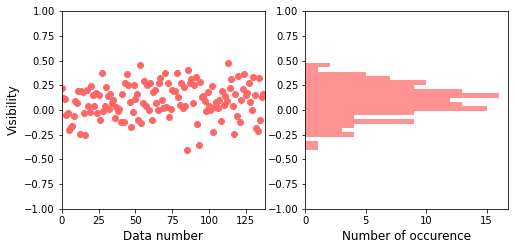

In [42]:
fig =plt.figure(figsize=[8,8])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(unique_trans_files))
# ax3.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax3.set_ylim(-1,1)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
# ax4.set_ylim(1.1*np.min(visibility_list),1/1*np.max(visibility_list))
ax4.set_ylim(-1,1)
ax4.set_xlabel('Number of occurence',fontsize=12)

In [43]:
threshold = 0.0

def createChiralImages(trans_files, visibility_list, threshold):
    image1_list = []
    image2_list = []
    for i in range(len(trans_files)):
        if visibility_list[i] < -threshold:
            image1_list.append(trans_files[i])
        elif visibility_list[i] > threshold:
            image2_list.append(trans_files[i])
    image1_ave = np.average(image1_list, axis=0)
    image2_ave = np.average(image2_list, axis=0)
    return image1_ave, image2_ave, len(image1_list), len(image2_list)

post_selected_images = createChiralImages(unique_trans_files, visibility_list, threshold)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

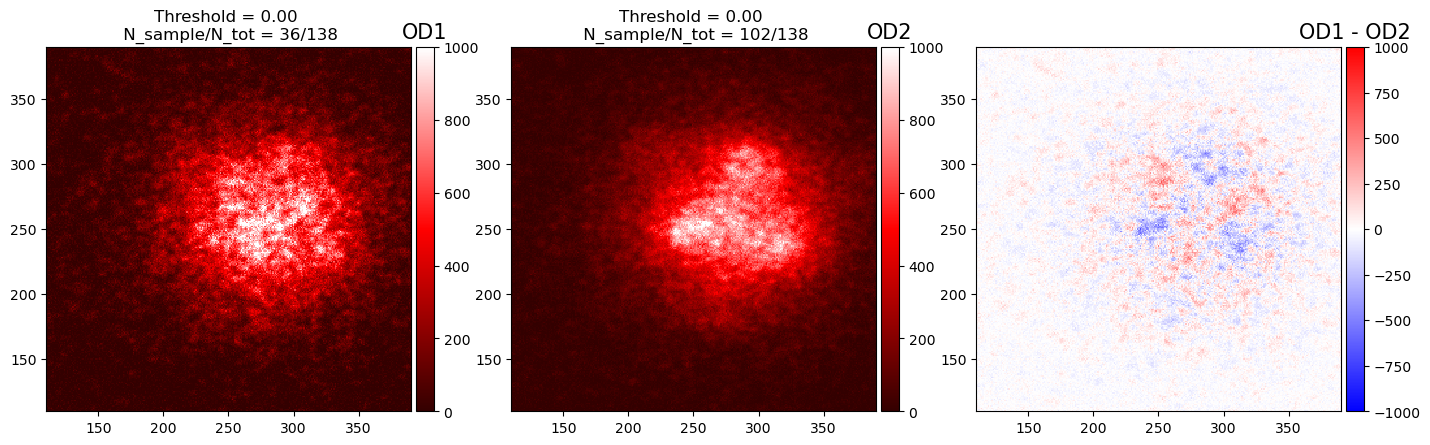

In [44]:
vmin = 00
vmax = 1000
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )


fig =plt.figure(figsize=[17,5],dpi=100)
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(post_selected_images[0], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("Threshold = %.02f \n N_sample/N_tot = %d/%d"%(threshold, post_selected_images[2], len(unique_trans_files)))
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"OD1", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
mappable = ax2.pcolormesh(post_selected_images[1], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("Threshold = %.02f \n N_sample/N_tot = %d/%d"%(threshold, post_selected_images[3], len(unique_trans_files)))
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"OD2", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
mappable =ax3.pcolormesh(post_selected_images[0] - post_selected_images[1],cmap='bwr', norm=norm, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
divider3 = make_axes_locatable(ax3)
ax_cb3 = divider3.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb3)
pp.ax.set_title(r"OD1 - OD2", fontsize=15)

plt.tight_layout

In [46]:
number_of_unique_trans_files = []
hist_list = []
chiral_imgs_list = []

momentum_peaks_C1_dx_list = [30, -31, 8]
momentum_peaks_C1_dy_list = [-20, -9, 31]
momentum_peaks_C2_dx_list = [-5, 35, -27]
momentum_peaks_C2_dy_list = [-29, 12, 24]

threshold = 0.0

for i in range(len(unique_param)):
    unique_param_index = i
    print(i)
    cx = centerx_list[unique_param_index]
    cy = centery_list[unique_param_index]
    r = 9
    unique_trans_files = createUniqueTransFiles(postSelected_img_trans_list, postSelected_scan_param_list, unique_param, unique_param_index)
    number_of_unique_trans_files.append(len(unique_trans_files))
    subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)
    hist_list.append(calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r))
    chiral_imgs_list.append(createChiralImages(unique_trans_files, hist_list[-1][1], threshold))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


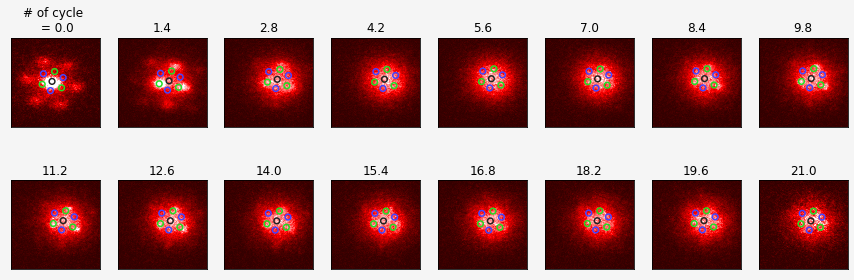

In [50]:
column_number = 8
row_number = 2
vmax = 1000

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.1)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            cx = centerx_list[column_number*i+j]
            cy = centery_list[column_number*i+j]
            subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)
            axes[i,j].pcolormesh(postSelected_img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title("# of cycle \n = %.01f"%(NoOfCycle[column_number*i+j]))
            else:
                axes[i,j].set_title("%.01f"%(NoOfCycle[column_number*i+j]))
            for k in range(len(shift_dx_list)):
                if k == 0:
                    color = '#222222'
                elif k<4:
                    color = '#22dd22'
                else:
                    color = '#4444ff'
                region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[k], y=subROI_cy_list[k]), radius=r)
                region.plot(ax=axes[i,j], color=color, lw=1.5)
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

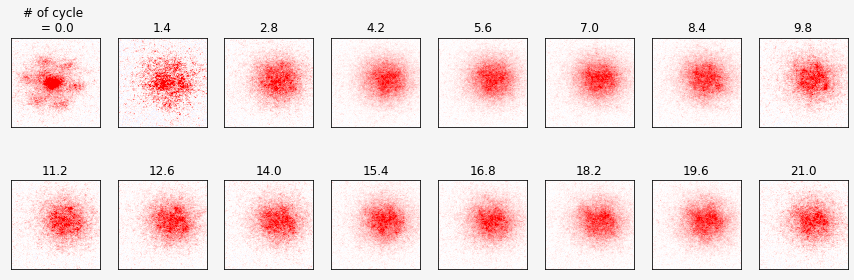

In [53]:
column_number = 8
row_number = 2
vmax = 1000
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.1)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(chiral_imgs_list[column_number*i+j][0],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title("# of cycle \n = %.01f"%(NoOfCycle[column_number*i+j]))
            else:
                axes[i,j].set_title("%.01f"%(NoOfCycle[column_number*i+j]))
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

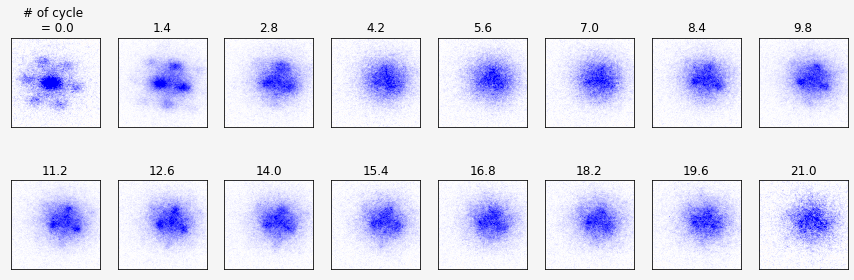

In [54]:

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.1)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(-chiral_imgs_list[column_number*i+j][1],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title("# of cycle \n = %.01f"%(NoOfCycle[column_number*i+j]))
            else:
                axes[i,j].set_title("%.01f"%(NoOfCycle[column_number*i+j]))
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)

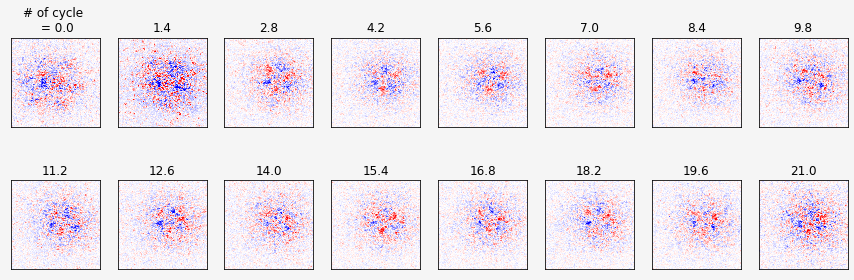

In [58]:
column_number = 8
row_number = 2
vmax = 500
norm = mcolors.TwoSlopeNorm( vcenter=0.0, vmin=-vmax, vmax=vmax )

fig, axes = plt.subplots(row_number, column_number, figsize=(15,5), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.1)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[i,j].pcolormesh(chiral_imgs_list[column_number*i+j][0] - chiral_imgs_list[column_number*i+j][1],cmap='bwr', norm=norm, shading='auto')
            axes[i,j].set_aspect('equal')
            axes[i,j].set_xlim(xlim_1,xlim_2)
            axes[i,j].set_ylim(ylim_1,ylim_2)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)
            if i==0 and j==0:
                axes[i,j].set_title("# of cycle \n = %.01f"%(NoOfCycle[column_number*i+j]))
            else:
                axes[i,j].set_title("%.01f"%(NoOfCycle[column_number*i+j]))
        else:
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].yaxis.set_visible(False)